In [18]:
# ==== Cell 1: Imports & config ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

In [1]:
# ==== Cell 2: Paths & knobs ====
DATA_PATH = "../data/processed/pune_climate_with_co2.csv"  # <— we will use this dataset

DATE_COL  = "date"
TARGETS   = ["temp_C", "humidity_pct", "rainfall_mm"]      # run one-at-a-time or all
CO2_COL   = "co2_ppm"
RAIN_KEYS = ["rain", "precip"]                              # for monthly SUM

# Feature recipe (monthly)
LAGS   = [1, 3, 12]   # past months
ROLLS  = [3, 12]      # rolling means on TARGET only (leak-safe)
ALPHAS = [0.1, 1.0, 10.0]  # Ridge sweep

# Time split (by order, not random)
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-6

# Optional toggles (off by default)
USE_RAINFALL_LOG1P = False      # set True only for rainfall if you see extreme spikes
RAIN_CAP_PCTILE    = None       # e.g., 99 to gently cap rainfall outliers before modeling

In [20]:
# ==== Cell 3: Load daily data (no writes) ====
df = pd.read_csv(DATA_PATH)
assert DATE_COL in df.columns, f"Missing '{DATE_COL}' in {DATA_PATH}"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.sort_values(DATE_COL).reset_index(drop=True)

# sanity: required columns present
req = [DATE_COL, "temp_C", "humidity_pct", "rainfall_mm", CO2_COL]
missing = [c for c in req if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

print("Rows:", len(df))
print("Date coverage:", df[DATE_COL].min(), "→", df[DATE_COL].max())
df.head()

Rows: 27029
Date coverage: 1951-01-01 00:00:00 → 2024-12-31 00:00:00


,date,temp_C,humidity_pct,solar_MJ,rainfall_mm,co2_ppm
0,1951-01-01,NaN,NaN,NaN,0.0,NaN
1,1951-01-02,NaN,NaN,NaN,0.0,NaN
2,1951-01-03,NaN,NaN,NaN,0.0,NaN
3,1951-01-04,NaN,NaN,NaN,0.0,NaN
4,1951-01-05,NaN,NaN,NaN,0.0,NaN


In [21]:
# ==== Cell 4: Aggregate to MONTHLY (sum rainfall, mean others) ====
def to_monthly_agg(d: pd.DataFrame, date_col=DATE_COL, rain_keys=("rain","precip")) -> pd.DataFrame:
    m = d.copy()
    m["Year"]  = m[date_col].dt.year
    m["Month"] = m[date_col].dt.month
    agg = {}
    for c in m.columns:
        if c in [date_col, "Year", "Month"]:
            continue
        if np.issubdtype(m[c].dtype, np.number):
            if any(k in c.lower() for k in rain_keys):
                agg[c] = "sum"
            else:
                agg[c] = "mean"
    out = m.groupby(["Year","Month"], as_index=False).agg(agg)
    out["date"] = pd.to_datetime(dict(year=out["Year"], month=out["Month"], day=1)) + pd.offsets.MonthEnd(0)
    out = out.sort_values("date").reset_index(drop=True)

    # optional rainfall transforms (default OFF)
    if "rainfall_mm" in out.columns:
        if RAIN_CAP_PCTILE is not None:
            cap = np.nanpercentile(out["rainfall_mm"], RAIN_CAP_PCTILE)
            out["rainfall_mm"] = np.clip(out["rainfall_mm"], None, cap)
        if USE_RAINFALL_LOG1P:
            out["rainfall_mm"] = np.log1p(out["rainfall_mm"])

    # downcast to float32 to stay memory-light on M1
    for c in out.columns:
        if np.issubdtype(out[c].dtype, np.floating):
            out[c] = out[c].astype("float32")
    return out

df_monthly = to_monthly_agg(df, rain_keys=RAIN_KEYS)
print("Monthly rows:", len(df_monthly))
df_monthly.head()

Monthly rows: 888


,Year,Month,temp_C,humidity_pct,solar_MJ,rainfall_mm,co2_ppm,date
0,1951,1,NaN,NaN,NaN,0.478959,NaN,1951-01-31
1,1951,2,NaN,NaN,NaN,0.000000,NaN,1951-02-28
2,1951,3,NaN,NaN,NaN,0.000000,NaN,1951-03-31
3,1951,4,NaN,NaN,NaN,1.907321,NaN,1951-04-30
4,1951,5,NaN,NaN,NaN,46.216663,NaN,1951-05-31


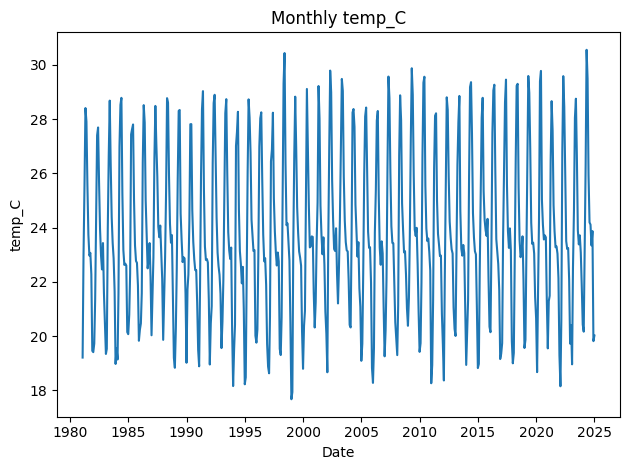

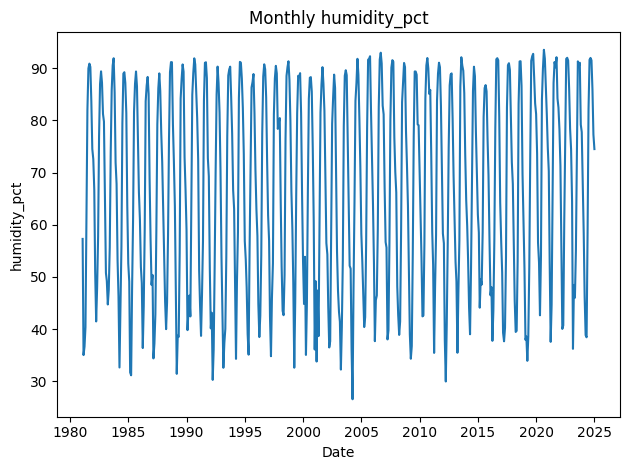

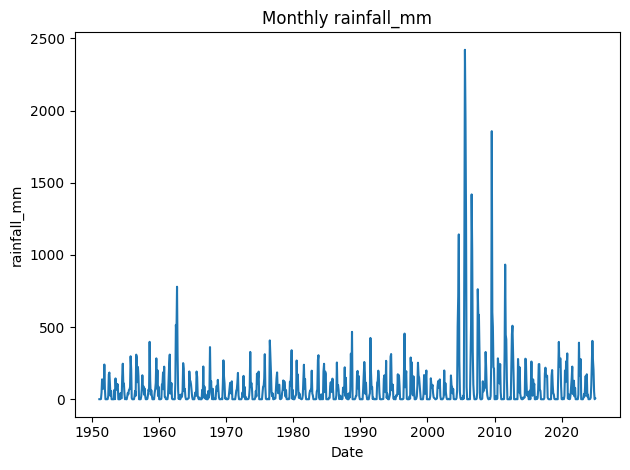

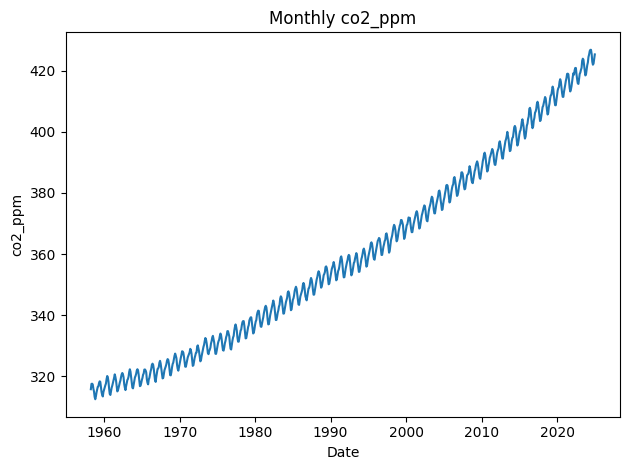

In [22]:
# ==== Cell 5: Quick monthly sanity plots ====
for col in [c for c in ["temp_C","humidity_pct","rainfall_mm",CO2_COL] if c in df_monthly.columns]:
    plt.figure()
    plt.plot(df_monthly["date"], df_monthly[col])
    plt.title(f"Monthly {col}")
    plt.xlabel("Date"); plt.ylabel(col); plt.tight_layout()

In [23]:
# ==== Cell 6: Feature engineering ====
def make_features(df_in: pd.DataFrame, target_col: str, date_col="date",
                  lags=LAGS, rolls=ROLLS) -> pd.DataFrame:
    num_cols = [c for c in df_in.columns
                if c not in [date_col, "Year", "Month"]
                and np.issubdtype(df_in[c].dtype, np.number)]

    out = df_in[[date_col] + num_cols].copy()
    out["month"] = out[date_col].dt.month
    out["m_sin"] = np.sin(2*np.pi*out["month"]/12.0)
    out["m_cos"] = np.cos(2*np.pi*out["month"]/12.0)

    # lag ALL numeric features (includes CO2) to avoid leakage
    for c in num_cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)

    # rolling means on TARGET only (use past only)
    for w in rolls:
        out[f"{target_col}_rollmean{w}"] = out[target_col].shift(1).rolling(w, min_periods=w).mean()

    # supervised target: t+1 month
    out[target_col + "_target"] = df_in[target_col].shift(-1)

    # drop rows created by lags/rolls and the last shifted target
    out = out.dropna().reset_index(drop=True)
    return out

In [24]:
# ==== Cell 7: Time-based split ====
def time_splits(df_in: pd.DataFrame, date_col="date",
                train_frac=TRAIN_FRAC, val_frac=VAL_FRAC):
    N = len(df_in)
    tr_end = int(np.floor(train_frac * N))
    va_end = int(np.floor((train_frac + val_frac) * N))
    split = {
        "train_start": df_in.loc[0, date_col],
        "train_end":   df_in.loc[tr_end-1, date_col],
        "val_start":   df_in.loc[tr_end, date_col],
        "val_end":     df_in.loc[va_end-1, date_col],
        "test_start":  df_in.loc[va_end, date_col],
        "test_end":    df_in.loc[N-1, date_col],
    }
    return split, tr_end, va_end

split_summary, tr_end, va_end = time_splits(df_monthly, "date")
split_summary

{'train_start': Timestamp('1951-01-31 00:00:00'),
 'train_end': Timestamp('2002-09-30 00:00:00'),
 'val_start': Timestamp('2002-10-31 00:00:00'),
 'val_end': Timestamp('2013-10-31 00:00:00'),
 'test_start': Timestamp('2013-11-30 00:00:00'),
 'test_end': Timestamp('2024-12-31 00:00:00')}

In [25]:
# ==== Cell 8: Naive baseline (t+1 = last observed) ====
def eval_naive_last_value(df_in: pd.DataFrame, target: str, split: dict, date_col="date"):
    series = df_in[[date_col, target]].copy()
    series["y_hat"] = series[target].shift(1)  # predict next month as last month
    mask_te = (series[date_col] >= split["test_start"]) & (series[date_col] <= split["test_end"])
    te = series.loc[mask_te].dropna()

    mae = mean_absolute_error(te[target], te["y_hat"])
    mse = mean_squared_error(te[target], te["y_hat"])   # works on all sklearn versions
    rmse = np.sqrt(mse)
    r2 = r2_score(te[target], te["y_hat"])

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Example (temp)
naive_temp = eval_naive_last_value(df_monthly, "temp_C", split_summary)
naive_temp

{'MAE': 1.7567023038864136, 'RMSE': 2.22332592682222, 'R2': 0.492877721786499}

In [26]:
# ==== Hotfix Cell: version-proof RMSE + patched helpers (replaces Cell 9) ====
from sklearn.metrics import mean_squared_error

def rmse_legacy(y_true, y_pred):
    # Works on all sklearn versions
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_model(model, X_t, y_t):
    y_hat = model.predict(X_t)
    return {
        "MAE": mean_absolute_error(y_t, y_hat),
        "RMSE": rmse_legacy(y_t, y_hat),   # <-- no 'squared=False'
        "R2": r2_score(y_t, y_hat),
        "y_hat": y_hat,
    }

def run_baseline_for_target(df_monthly: pd.DataFrame, target: str, split: dict, seed=SEED):
    data = make_features(df_monthly, target)
    X = data.drop(columns=[target + "_target"])
    y = data[target + "_target"]

    in_range = lambda s,a,b: (s >= a) & (s <= b)
    tr_mask = in_range(X["date"], split["train_start"], split["train_end"])
    va_mask = in_range(X["date"], split["val_start"],   split["val_end"])
    te_mask = in_range(X["date"], split["test_start"],  split["test_end"])

    feat_cols = [c for c in X.columns if c not in ["date","month"]]
    X_tr, y_tr = X.loc[tr_mask, feat_cols], y.loc[tr_mask]
    X_va, y_va = X.loc[va_mask, feat_cols], y.loc[va_mask]
    X_te, y_te = X.loc[te_mask, feat_cols], y.loc[te_mask]

    # Ridge (tiny alpha sweep)
    best_ridge, best_rmse = None, np.inf
    for alpha in ALPHAS:
        ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=alpha, random_state=seed))])
        ridge.fit(X_tr, y_tr)
        rmse_va = rmse_legacy(y_va, ridge.predict(X_va))   # <-- patched
        if rmse_va < best_rmse:
            best_rmse, best_ridge = rmse_va, ridge
    ridge_res = eval_model(best_ridge, X_te, y_te)

    # RandomForest (fast, robust)
    rf = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_leaf=1,
                               n_jobs=-1, random_state=seed)
    rf.fit(X_tr, y_tr)
    rf_res = eval_model(rf, X_te, y_te)

    # pick best by RMSE & plot
    best_name, best_res = ("Ridge", ridge_res) if ridge_res["RMSE"] <= rf_res["RMSE"] else ("RandomForest", rf_res)

    plt.figure()
    plt.plot(X.loc[te_mask, "date"], y_te, label="Actual")
    plt.plot(X.loc[te_mask, "date"], best_res["y_hat"], label=f"Predicted ({best_name})")
    plt.title(f"{target} — Test: Actual vs Predicted ({best_name})")
    plt.xlabel("Date"); plt.ylabel(target); plt.legend(); plt.tight_layout()

    return {
        "target": target,
        "naive": eval_naive_last_value(df_monthly, target, split),  # your Cell 8 already patched
        "ridge": ridge_res,
        "rf": rf_res,
        "best": best_name
    }

,model,MAE,RMSE,R2
0,Naive(t-1),1.7567,2.2233,0.4929
1,Ridge(best),0.6836,0.8846,0.9199
2,RandomForest,0.6472,0.8796,0.9208


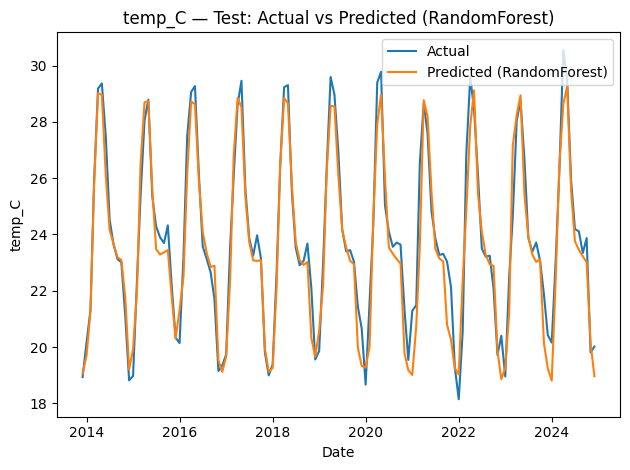

In [27]:
# ==== Cell 10: Run ONE target (start with temperature) ====
TARGET_TO_RUN = "temp_C"  # change to "humidity_pct" or "rainfall_mm" later
assert TARGET_TO_RUN in df_monthly.columns, f"{TARGET_TO_RUN} not found"

res = run_baseline_for_target(df_monthly, TARGET_TO_RUN, split_summary)

summary_one = pd.DataFrame([
    {"model": "Naive(t-1)",   **res["naive"]},
    {"model": "Ridge(best)",  **{k:v for k,v in res["ridge"].items() if k != "y_hat"}},
    {"model": "RandomForest", **{k:v for k,v in res["rf"].items()    if k != "y_hat"}},
]).round(4)
summary_one

,target,model,MAE,RMSE,R2
0,temp_C,Naive(t-1),1.7567,2.2233,0.4929
1,temp_C,Ridge(best),0.6836,0.8846,0.9199
2,temp_C,RandomForest,0.6472,0.8796,0.9208
3,humidity_pct,Naive(t-1),8.8126,11.2290,0.6425
4,humidity_pct,Ridge(best),4.3885,5.6723,0.9094
5,humidity_pct,RandomForest,4.4011,5.5210,0.9142
6,rainfall_mm,Naive(t-1),60.2172,95.8150,0.1215
7,rainfall_mm,Ridge(best),60.8988,85.9667,0.2961
8,rainfall_mm,RandomForest,47.7465,71.4398,0.5139


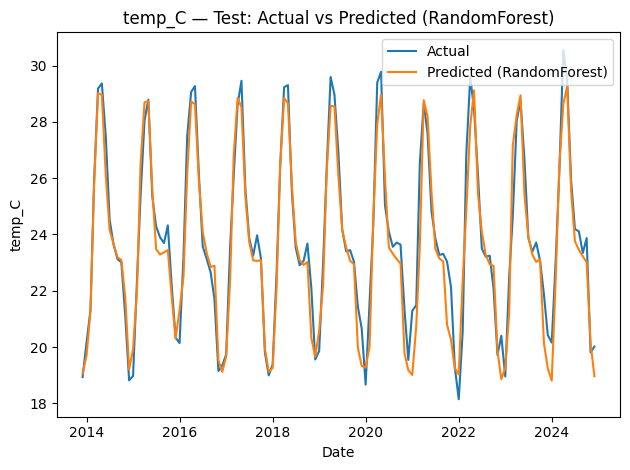

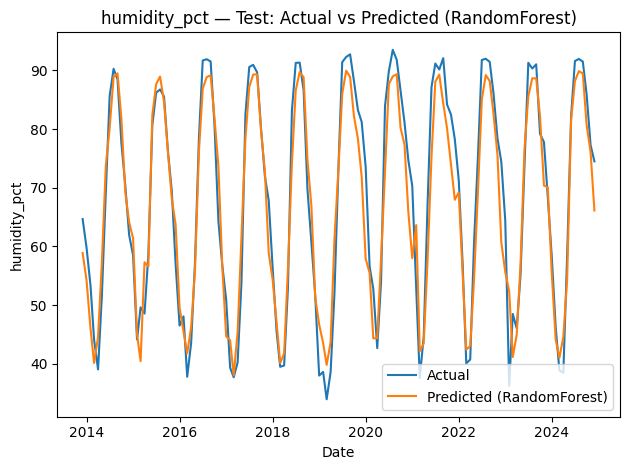

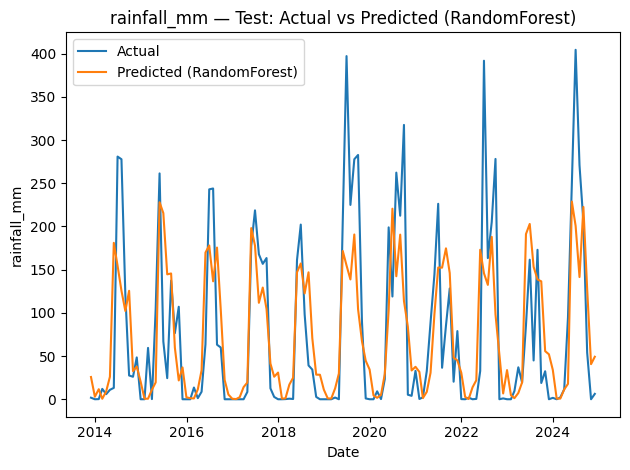

In [28]:
# ==== Cell 11: Run ALL targets (compact table) ====
rows = []
for tgt in [t for t in TARGETS if t in df_monthly.columns]:
    out = run_baseline_for_target(df_monthly, tgt, split_summary)
    rows.append({"target": tgt, "model": "Naive(t-1)",   **out["naive"]})
    rows.append({"target": tgt, "model": "Ridge(best)",  **{k:v for k,v in out["ridge"].items() if k != "y_hat"}})
    rows.append({"target": tgt, "model": "RandomForest", **{k:v for k,v in out["rf"].items()    if k != "y_hat"}})

pd.DataFrame(rows).round(4)

In [29]:
# ==== LSTM (Keras) for monthly t+1 ====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def run_lstm_for_target(df_monthly: pd.DataFrame, target: str, split: dict, seed=SEED):
    tf.keras.utils.set_random_seed(seed)
    data = make_features(df_monthly, target)
    X = data.drop(columns=[target + "_target"])
    y = data[target + "_target"]

    in_range = lambda s,a,b: (s >= a) & (s <= b)
    tr_mask = in_range(X["date"], split["train_start"], split["train_end"])
    va_mask = in_range(X["date"], split["val_start"],   split["val_end"])
    te_mask = in_range(X["date"], split["test_start"],  split["test_end"])

    feat_cols = [c for c in X.columns if c not in ["date","month"]]
    X_tr, y_tr = X.loc[tr_mask, feat_cols].values, y.loc[tr_mask].values
    X_va, y_va = X.loc[va_mask, feat_cols].values, y.loc[va_mask].values
    X_te, y_te = X.loc[te_mask, feat_cols].values, y.loc[te_mask].values

    # feed each row as a 1-step sequence (fast; we already have lag/roll features)
    X_tr = X_tr[:, None, :]
    X_va = X_va[:, None, :]
    X_te = X_te[:, None, :]

    model = keras.Sequential([
        layers.Input(shape=(1, X_tr.shape[2])),
        layers.LSTM(32),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mae")

    es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    model.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=200, batch_size=32, callbacks=[es], verbose=0)

    y_hat = model.predict(X_te, verbose=0).ravel()
    res = {
        "MAE": mean_absolute_error(y_te, y_hat),
        "RMSE": rmse_legacy(y_te, y_hat),
        "R2": r2_score(y_te, y_hat),
        "y_hat": y_hat
    }

    # Plot
    dates_te = X.loc[te_mask, "date"]
    plt.figure()
    plt.plot(dates_te, y_te, label="Actual")
    plt.plot(dates_te, y_hat, label="Predicted (LSTM)")
    plt.title(f"{target} — Test: Actual vs Predicted (LSTM)")
    plt.xlabel("Date"); plt.ylabel(target); plt.legend(); plt.tight_layout()
    return res

In [30]:
# ==== GRU (Keras) for monthly t+1 ====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def run_gru_for_target(df_monthly: pd.DataFrame, target: str, split: dict, seed=SEED):
    tf.keras.utils.set_random_seed(seed)
    data = make_features(df_monthly, target)
    X = data.drop(columns=[target + "_target"])
    y = data[target + "_target"]

    in_range = lambda s,a,b: (s >= a) & (s <= b)
    tr_mask = in_range(X["date"], split["train_start"], split["train_end"])
    va_mask = in_range(X["date"], split["val_start"],   split["val_end"])
    te_mask = in_range(X["date"], split["test_start"],  split["test_end"])

    feat_cols = [c for c in X.columns if c not in ["date","month"]]
    X_tr, y_tr = X.loc[tr_mask, feat_cols].values, y.loc[tr_mask].values
    X_va, y_va = X.loc[va_mask, feat_cols].values, y.loc[va_mask].values
    X_te, y_te = X.loc[te_mask, feat_cols].values, y.loc[te_mask].values

    X_tr = X_tr[:, None, :]
    X_va = X_va[:, None, :]
    X_te = X_te[:, None, :]

    model = keras.Sequential([
        layers.Input(shape=(1, X_tr.shape[2])),
        layers.GRU(32),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mae")

    es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    model.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=200, batch_size=32, callbacks=[es], verbose=0)

    y_hat = model.predict(X_te, verbose=0).ravel()
    res = {
        "MAE": mean_absolute_error(y_te, y_hat),
        "RMSE": rmse_legacy(y_te, y_hat),
        "R2": r2_score(y_te, y_hat),
        "y_hat": y_hat
    }

    dates_te = X.loc[te_mask, "date"]
    plt.figure()
    plt.plot(dates_te, y_te, label="Actual")
    plt.plot(dates_te, y_hat, label="Predicted (GRU)")
    plt.title(f"{target} — Test: Actual vs Predicted (GRU)")
    plt.xlabel("Date"); plt.ylabel(target); plt.legend(); plt.tight_layout()
    return res

In [31]:
# ==== Leaderboard: run all models for ALL targets, pick best per target ====
def leaderboard_all_targets(targets=None):
    targets = targets or [t for t in TARGETS if t in df_monthly.columns]
    rows = []
    best_rows = []

    for tgt in targets:
        base = run_baseline_for_target(df_monthly, tgt, split_summary)
        lstm = run_lstm_for_target(df_monthly, tgt, split_summary)
        gru  = run_gru_for_target(df_monthly,  tgt, split_summary)

        # Collect comparable rows (drop y_hat to keep table light)
        rows.extend([
            {"target": tgt, "model": "Naive(t-1)",    **base["naive"]},
            {"target": tgt, "model": "Ridge(best)",   **{k:v for k,v in base["ridge"].items() if k != "y_hat"}},
            {"target": tgt, "model": "RandomForest",  **{k:v for k,v in base["rf"].items()    if k != "y_hat"}},
            {"target": tgt, "model": "LSTM",          **{k:v for k,v in lstm.items() if k != "y_hat"}},
            {"target": tgt, "model": "GRU",           **{k:v for k,v in gru.items()  if k != "y_hat"}},
        ])

        # Best by RMSE for this target
        cur = [r for r in rows if r["target"] == tgt]
        best = min(cur, key=lambda r: r["RMSE"])
        best_rows.append({"target": tgt, "best_model": best["model"],
                          "RMSE": best["RMSE"], "MAE": best["MAE"], "R2": best["R2"]})

    all_df  = pd.DataFrame(rows).round(4).sort_values(["target", "RMSE", "MAE"])
    best_df = pd.DataFrame(best_rows).round(4).sort_values("target")

    print("⬇️ Full leaderboard (lower RMSE = better)")
    display(all_df)
    print("\n🏁 Best model per target")
    display(best_df)
    return all_df, best_df

# Example:
# all_df, best_df = leaderboard_all_targets()

In [32]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())
print("MPS available (Apple Silicon):", tf.config.list_physical_devices('GPU'))

TF version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
MPS available (Apple Silicon): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
